# <center>  Building models

### Table of contents  
  
1. [Funcsions](#funcs)


2. [Data](#data)


3. [Models](#mods)

    3.1 [Logistic Regression](#LG)
    
    3.2 [Naive Bayes](#NB)
    
    3.3 [Stochastic Gradient Descent](#SGD)
    
    3.4 [K-Nearest Neighbours](#KN)
    
    3.5 [Decision Tree](#DT)
    
    3.6 [Random Forest](#RF)
    
    3.7 [Support Vector Machine](#SVM)
    
    3.8 [XGBoost](#XGB)


4. [Cross-validation](#CV)


5. [Recommendations](#rec)




In [1]:
# libs
%pylab inline
import pandas as pd
import pandas_profiling
import numpy
from numpy import where
import pickle
import json

from custom_graphs import model_performance

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.manifold import TSNE

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, balanced_accuracy_score, precision_recall_curve
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# visualization
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


## Functions <a name="funcs"></a>

In [2]:
def F1(y_test, y_pred):
    return f1_score(y_test, y_pred)

In [3]:
def make_pipeline(numeric, model):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric)
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data, y_train, y_test):    

    model = pipeline.fit(train_data, y_train)
    y_train_pred = model.predict(train_data)
    
    predictions = model.predict(test_data)
    pred_prob = model.predict_proba(test_data)

    print('Train F1 is {}'.format(F1(y_train, y_train_pred)))
    print('Test F1 is {}'.format(F1(y_test, predictions)))
    
    return predictions, pred_prob

In [4]:
def sow_conf_matrix(y_test, predictions):
    
    cm = confusion_matrix(y_test, predictions)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Logistic Regression Confusion Matrix', size = 15);
    plt.show()

In [5]:
def show_metrics(y_test, predictions, average = ''):
    
    accuracy_macro_average = accuracy_score(y_test, predictions)
    accuracy_weighted_average = accuracy_score(y_test, predictions)

    precision_macro_average = precision_score(y_test, predictions, average='macro')
    precision_weighted_average = precision_score(y_test, predictions, average='weighted')

    recall_macro_average = recall_score(y_test, predictions, average='macro')
    recall_weighted_average = recall_score(y_test, predictions, average='weighted')

    f1_macro_average = f1_score(y_test, predictions, average='macro')
    f1_weighted_average = f1_score(y_test, predictions, average='weighted')

    roc_auc_macro_average = roc_auc_score(y_test, predictions, average='macro')
    roc_auc_weighted_average = roc_auc_score(y_test, predictions, average='weighted')

    print(f'Accuracy (macro average): {round(accuracy_macro_average*100, 4)}%')
    print(f'Accuracy (weighted average): {round(accuracy_weighted_average*100, 4)}%\n')

    print(f'Precision (macro average): {round(precision_macro_average*100, 4)}%')
    print(f'Precision (weighted average): {round(precision_weighted_average*100, 4)}%\n')

    print(f'Recall (macro average): {round(recall_macro_average*100, 4)}%')
    print(f'Recall (weighted average): {round(recall_weighted_average*100, 4)}%\n')

    print(f'F1 score (macro average): {round(f1_macro_average*100, 2)}%')
    print(f'F1 score (weighted average): {round(f1_weighted_average*100, 2)}%\n')

    print(f'ROC-AUC score (macro average): {round(roc_auc_macro_average*100, 2)}%')
    print(f'ROC-AUC score (weighted average): {round(roc_auc_weighted_average*100, 2)}%\n')

    print(classification_report(y_test, predictions))

## Data <a name="data"></a>

In [6]:
y_smote = pd.read_pickle('y_smote.pkl')
X_smote = pd.read_pickle('X_smote.pkl')

In [7]:
X_smote.head()

,popularity,explicit,duration_ms,danceability,energy,track_key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,classical,drill,hip hop,house,indie,metal,others,pop,r&b,rap,rock,techno,trap
0,65,0,142163,0.16,0.08,5,-28.17,1,0.04,0.96,0.76,0.10,0.06,139.34,3,0,0,0,0,0,0,1,0,0,0,0,0,0
1,51,0,196153,0.72,0.67,4,-6.39,0,0.31,0.25,0.00,0.12,0.16,156.84,4,0,1,0,0,0,0,0,0,0,0,0,0,0
2,58,1,143529,0.81,0.62,8,-12.06,0,0.44,0.25,0.00,0.10,0.92,101.87,4,0,0,0,0,0,0,0,1,0,0,0,0,0
3,53,0,137647,0.71,0.46,11,-12.03,0,0.46,0.78,0.00,0.14,0.60,101.97,4,0,0,0,0,0,0,0,1,0,0,0,0,0
4,79,0,189780,0.60,0.80,5,-5.61,1,0.05,0.15,0.00,0.12,0.53,106.00,4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
X_smote.shape

(3062, 28)

In [9]:
y_smote.value_counts()

0    1531
1    1531
Name: labels, dtype: int64

**train-test split**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

## Models <a name="mods"></a>

### Logistic Regression <a name="LG"></a>

In [11]:
pipeline = make_pipeline(X_train.columns, LogisticRegression())

predictions, prob = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 0.8096820123398196
Test F1 is 0.8066666666666668


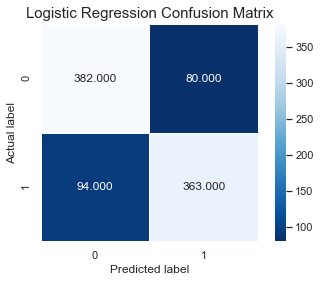

In [12]:
sow_conf_matrix(y_test, predictions)

In [13]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 81.0664%
Accuracy (weighted average): 81.0664%

Precision (macro average): 81.0967%
Precision (weighted average): 81.0921%

Recall (macro average): 81.0575%
Recall (weighted average): 81.0664%

F1 score (macro average): 81.06%
F1 score (weighted average): 81.06%

ROC-AUC score (macro average): 81.06%
ROC-AUC score (weighted average): 81.06%

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       462
           1       0.82      0.79      0.81       457

    accuracy                           0.81       919
   macro avg       0.81      0.81      0.81       919
weighted avg       0.81      0.81      0.81       919



### Naive Bayes <a name="NB"></a>

In [14]:
var_smoothing = np.logspace(0,-9, num=100)

hyperparameters = dict(var_smoothing=var_smoothing)

In [15]:
%%time
best_model = GridSearchCV(estimator=GaussianNB(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Wall time: 6.93 s


In [16]:
var_smoothing = best_model.best_estimator_.get_params()['var_smoothing']

print(f'Best var_smoothing: {var_smoothing}')

Best var_smoothing: 1.2328467394420635e-09


In [17]:
pipeline = make_pipeline(X_train.columns, GaussianNB(var_smoothing=var_smoothing))

predictions, prob = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 0.7332173913043479
Test F1 is 0.7365813377374071


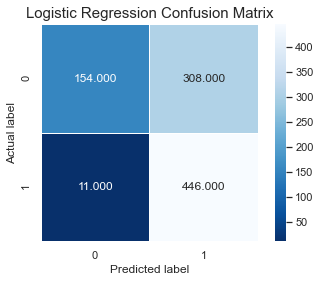

In [18]:
sow_conf_matrix(y_test, predictions)

In [19]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 65.2884%
Accuracy (weighted average): 65.2884%

Precision (macro average): 76.2423%
Precision (weighted average): 76.3353%

Recall (macro average): 65.4632%
Recall (weighted average): 65.2884%

F1 score (macro average): 61.39%
F1 score (weighted average): 61.32%

ROC-AUC score (macro average): 65.46%
ROC-AUC score (weighted average): 65.46%

              precision    recall  f1-score   support

           0       0.93      0.33      0.49       462
           1       0.59      0.98      0.74       457

    accuracy                           0.65       919
   macro avg       0.76      0.65      0.61       919
weighted avg       0.76      0.65      0.61       919



### Stochastic Gradient Descent <a name="SGD"></a>

In [20]:
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']


#Convert to dictionary
hyperparameters = dict(loss=loss, learning_rate=learning_rate)

In [21]:
%%time
best_model = GridSearchCV(estimator=SGDClassifier(eta0=0.01),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Wall time: 11.6 s


In [22]:
loss = best_model.best_estimator_.get_params()['loss']
learning_rate = best_model.best_estimator_.get_params()['learning_rate']

print(f'Best loss: {loss}')
print(f'Best learning_rate: {learning_rate}')

Best loss: modified_huber
Best learning_rate: adaptive


In [23]:
pipeline = make_pipeline(X_train.columns, SGDClassifier(loss=loss, learning_rate=learning_rate, eta0=0.01))

predictions, prob = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 0.8102710413694723
Test F1 is 0.8053097345132744


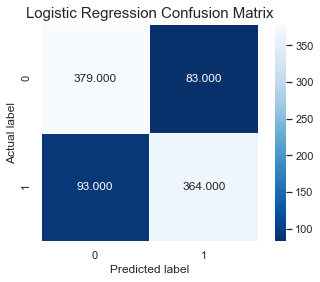

In [24]:
sow_conf_matrix(y_test, predictions)

In [25]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 80.8487%
Accuracy (weighted average): 80.8487%

Precision (macro average): 80.8642%
Precision (weighted average): 80.8611%

Recall (macro average): 80.8423%
Recall (weighted average): 80.8487%

F1 score (macro average): 80.84%
F1 score (weighted average): 80.85%

ROC-AUC score (macro average): 80.84%
ROC-AUC score (weighted average): 80.84%

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       462
           1       0.81      0.80      0.81       457

    accuracy                           0.81       919
   macro avg       0.81      0.81      0.81       919
weighted avg       0.81      0.81      0.81       919



### K-Nearest Neighbours <a name="KN"></a>

In [26]:
n_neighbors = list(range(1,30))
leaf_size = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [27]:
%%time
best_model = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 1682 candidates, totalling 16820 fits
Wall time: 2min 53s


In [28]:
n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']
leaf_size = best_model.best_estimator_.get_params()['leaf_size']
p = best_model.best_estimator_.get_params()['p']

print(f'Best n_neighbors: {n_neighbors}')
print(f'Best leaf_size: {leaf_size}')
print(f'Best p: {p}')

Best n_neighbors: 1
Best leaf_size: 1
Best p: 1


In [29]:
pipeline = make_pipeline(X_train.columns, KNeighborsClassifier(n_neighbors=n_neighbors, leaf_size=leaf_size, p=p))

predictions, prob = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 1.0
Test F1 is 0.8268041237113402


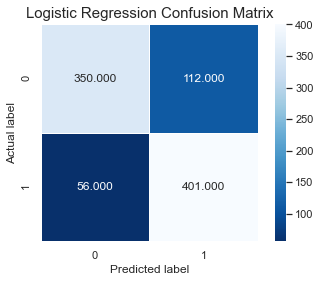

In [30]:
sow_conf_matrix(y_test, predictions)

In [31]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 81.7193%
Accuracy (weighted average): 81.7193%

Precision (macro average): 82.1873%
Precision (weighted average): 82.2091%

Recall (macro average): 81.7519%
Recall (weighted average): 81.7193%

F1 score (macro average): 81.66%
F1 score (weighted average): 81.66%

ROC-AUC score (macro average): 81.75%
ROC-AUC score (weighted average): 81.75%

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       462
           1       0.78      0.88      0.83       457

    accuracy                           0.82       919
   macro avg       0.82      0.82      0.82       919
weighted avg       0.82      0.82      0.82       919



### Decision Tree <a name="DT"></a>

In [32]:
criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth = [2, 3, 5, 10, 20]
min_samples_leaf = [5, 10, 20, 50, 100]


#Convert to dictionary
hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [33]:
%%time
best_model = GridSearchCV(estimator=DecisionTreeClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Wall time: 7.7 s


In [34]:
criterion = best_model.best_estimator_.get_params()['criterion']
splitter = best_model.best_estimator_.get_params()['splitter']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_samples_leaf = best_model.best_estimator_.get_params()['min_samples_leaf']

print(f'Best criterion: {criterion}')
print(f'Best splitter: {splitter}')
print(f'Best max_depth: {max_depth}')
print(f'Best min_samples_leaf: {min_samples_leaf}')

Best criterion: entropy
Best splitter: random
Best max_depth: 20
Best min_samples_leaf: 5


In [39]:
pipeline = make_pipeline(X_train.columns, DecisionTreeClassifier(criterion=criterion,
                                       splitter=splitter,
                                       max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf))

predictions, prob = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 0.885539331135186
Test F1 is 0.7654867256637169


[Text(0.7019285115227538, 0.9722222222222222, 'X[9] <= 0.213\nentropy = 1.0\nsamples = 2143\nvalue = [1069, 1074]'),
 Text(0.5543821105600933, 0.9166666666666666, 'X[25] <= 0.17\nentropy = 0.972\nsamples = 1591\nvalue = [640, 951]'),
 Text(0.3864771732788798, 0.8611111111111112, 'X[22] <= -0.237\nentropy = 0.951\nsamples = 1473\nvalue = [546, 927]'),
 Text(0.24950773045507585, 0.8055555555555556, 'X[16] <= 1.857\nentropy = 0.831\nsamples = 868\nvalue = [228, 640]'),
 Text(0.21371791131855308, 0.75, 'X[21] <= 1.617\nentropy = 0.798\nsamples = 843\nvalue = [204, 639]'),
 Text(0.165475495915986, 0.6944444444444444, 'X[20] <= 6.396\nentropy = 0.682\nsamples = 669\nvalue = [121, 548]'),
 Text(0.1279171528588098, 0.6388888888888888, 'X[18] <= -0.182\nentropy = 0.628\nsamples = 648\nvalue = [102, 546]'),
 Text(0.08897316219369895, 0.5833333333333334, 'X[17] <= 2.656\nentropy = 0.526\nsamples = 564\nvalue = [67, 497]'),
 Text(0.056592765460910154, 0.5277777777777778, 'X[23] <= 3.83\nentropy = 

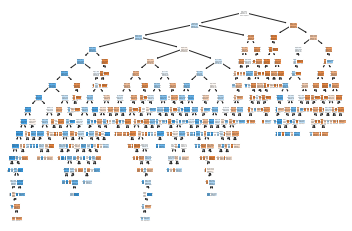

In [40]:
tree.plot_tree(pipeline['model'], filled=True)

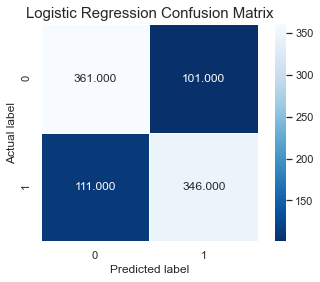

In [41]:
sow_conf_matrix(y_test, predictions)

In [42]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 76.9314%
Accuracy (weighted average): 76.9314%

Precision (macro average): 76.944%
Precision (weighted average): 76.9415%

Recall (macro average): 76.9248%
Recall (weighted average): 76.9314%

F1 score (macro average): 76.93%
F1 score (weighted average): 76.93%

ROC-AUC score (macro average): 76.92%
ROC-AUC score (weighted average): 76.92%

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       462
           1       0.77      0.76      0.77       457

    accuracy                           0.77       919
   macro avg       0.77      0.77      0.77       919
weighted avg       0.77      0.77      0.77       919



### Random Forest <a name="RF"></a>

In [43]:
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
max_depth = [40, 50, 60, 70]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,
                      max_depth=max_depth,
                      min_samples_split=min_samples_split,
                      min_samples_leaf=min_samples_leaf,
                      bootstrap=bootstrap)

In [39]:
%%time
best_model = GridSearchCV(estimator=RandomForestClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits
Wall time: 4h 45min 19s


In [188]:
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_samples_split = best_model.best_estimator_.get_params()['min_samples_split']
min_samples_leaf = best_model.best_estimator_.get_params()['min_samples_leaf']
bootstrap = best_model.best_estimator_.get_params()['bootstrap']

print(f'Best n_estimators: {n_estimators}')
print(f'Best max_depth: {max_depth}')
print(f'Best min_samples_split: {min_samples_split}')
print(f'Best min_samples_leaf: {min_samples_leaf}')
print(f'Best bootstrap: {bootstrap}')

KeyError: 'min_samples_split'

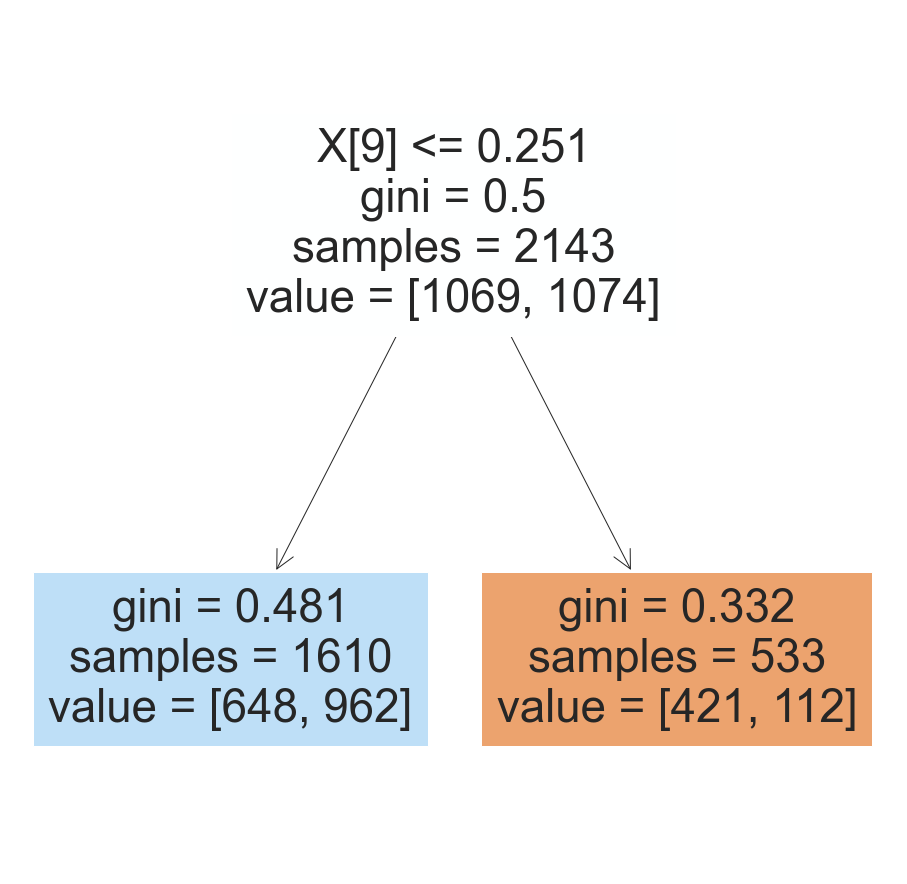

Train F1 is 0.745346869712352
Test F1 is 0.7246376811594203


In [189]:
pipeline = make_pipeline(X_train.columns, RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       bootstrap=bootstrap))

predictions = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

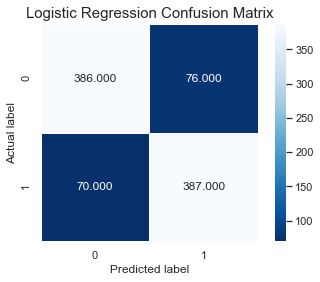

In [42]:
sow_conf_matrix(y_test, predictions)

In [43]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 84.1132%
Accuracy (weighted average): 84.1132%

Precision (macro average): 84.1172%
Precision (weighted average): 84.1201%

Recall (macro average): 84.1162%
Recall (weighted average): 84.1132%

F1 score (macro average): 84.11%
F1 score (weighted average): 84.11%

ROC-AUC score (macro average): 84.12%
ROC-AUC score (weighted average): 84.12%

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       462
           1       0.84      0.85      0.84       457

    accuracy                           0.84       919
   macro avg       0.84      0.84      0.84       919
weighted avg       0.84      0.84      0.84       919



### Support Vector Machine <a name="SVM"></a>

In [44]:
C = [0.1, 1, 10, 100]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10]

#Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma)

In [45]:
%%time
best_model = GridSearchCV(estimator=SVC(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Wall time: 57.6 s


In [46]:
C = best_model.best_estimator_.get_params()['C']
gamma = best_model.best_estimator_.get_params()['gamma']

print(f'Best C: {C}')
print(f'Best gamma: {gamma}')

Best C: 1
Best gamma: 0.001


In [47]:
pipeline = make_pipeline(X_train.columns, SVC(C=C, gamma=gamma))

predictions = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 0.8080717488789237
Test F1 is 0.8158168574401665


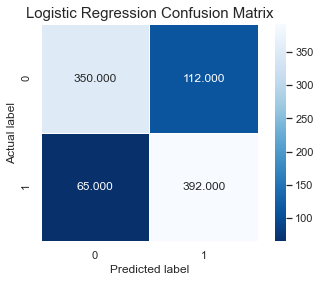

In [48]:
sow_conf_matrix(y_test, predictions)

In [49]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 80.7399%
Accuracy (weighted average): 80.7399%

Precision (macro average): 81.0576%
Precision (weighted average): 81.0754%

Recall (macro average): 80.7672%
Recall (weighted average): 80.7399%

F1 score (macro average): 80.7%
F1 score (weighted average): 80.69%

ROC-AUC score (macro average): 80.77%
ROC-AUC score (weighted average): 80.77%

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       462
           1       0.78      0.86      0.82       457

    accuracy                           0.81       919
   macro avg       0.81      0.81      0.81       919
weighted avg       0.81      0.81      0.81       919



### XGBoost <a name="XGB"></a>

In [50]:
eta = [0.2, 0.3, 0.4, 0.5]
max_depth = [0.3, 0.5, 0.8, 1]
min_child_weight = [3, 4, 5, 8, 12, 16, 20]

#Convert to dictionary
hyperparameters = dict(eta=eta,
                      max_depth=max_depth,
                      min_child_weight=min_child_weight)

In [51]:
%%time
best_model = GridSearchCV(estimator=XGBClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
Wall time: 26.4 s


In [52]:
eta = best_model.best_estimator_.get_params()['eta']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_child_weight = best_model.best_estimator_.get_params()['min_child_weight']

print(f'Best eta: {eta}')
print(f'Best max_depth: {max_depth}')
print(f'Best min_child_weight: {min_child_weight}')

Best eta: 0.4
Best max_depth: 1
Best min_child_weight: 3


In [53]:
pipeline = make_pipeline(X_train.columns, XGBClassifier(eta=eta, max_depth=max_depth, min_child_weight=min_child_weight))

predictions = fit_pipeline(pipeline, X_train, X_test, y_train, y_test)

Train F1 is 0.8442028985507246
Test F1 is 0.8174097664543524


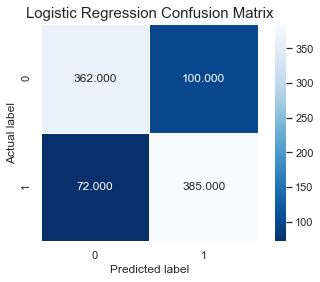

In [54]:
sow_conf_matrix(y_test, predictions)

In [55]:
show_metrics(y_test, predictions, average='')

Accuracy (macro average): 81.284%
Accuracy (weighted average): 81.284%

Precision (macro average): 81.3958%
Precision (weighted average): 81.4068%

Recall (macro average): 81.3%
Recall (weighted average): 81.284%

F1 score (macro average): 81.27%
F1 score (weighted average): 81.27%

ROC-AUC score (macro average): 81.3%
ROC-AUC score (weighted average): 81.3%

              precision    recall  f1-score   support

           0       0.83      0.78      0.81       462
           1       0.79      0.84      0.82       457

    accuracy                           0.81       919
   macro avg       0.81      0.81      0.81       919
weighted avg       0.81      0.81      0.81       919



## Cross-validation <a name="CV"></a>

In [71]:
# Let's initialize algorithms with the best parameters

lr_clf = LogisticRegression()

nb_clf = GaussianNB(var_smoothing=var_smoothing)

sgd_clf = SGDClassifier(loss=loss, learning_rate=learning_rate, eta0=0.01)

knn_clf = KNeighborsClassifier(n_neighbors=1, leaf_size=1, p=1)

dt_clf = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=20, min_samples_leaf=5)

forest_clf = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=70,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=1,
                                       bootstrap=bootstrap)
svm_clf = SVC(C=C, gamma=gamma)

xgb_clf = XGBClassifier(eta=eta, max_depth=1, min_child_weight=min_child_weight)

scoring = 'f1'
cv = 5

# Let's calculate the quality metric using cross-validation

lr_acc_score = cross_val_score(lr_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
nb_acc_score = cross_val_score(nb_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
sgd_acc_score = cross_val_score(sgd_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
knn_acc_score = cross_val_score(knn_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
dt_acc_score = cross_val_score(dt_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
forest_acc_score = cross_val_score(forest_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
svm_acc_score = cross_val_score(svm_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()
xgb_acc_score = cross_val_score(xgb_clf, X_smote, y_smote, scoring=scoring, cv=cv).mean()

# Let's derive algorithms in descending order of the quality of their work

leaderboard = sorted([
    ('Logistic Regression', lr_acc_score),
    ('Naive Bayes', nb_acc_score),
    ('SGD', sgd_acc_score),
    ('KNN', knn_acc_score),
    ('Decision Tree', dt_acc_score),
    ('Random Forest', forest_acc_score),
    ('SVC', svm_acc_score),
    ('XGBoost', xgb_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. Random Forest: 0.8388868061165539
2. XGBoost: 0.7869104794586843
3. Decision Tree: 0.748065913196489
4. KNN: 0.7012446199470942
5. Naive Bayes: 0.6925040758112555
6. SVC: 0.6296117009145826
7. Logistic Regression: 0.5850292215388305
8. SGD: 0.5553590848005839


As we can see, Random Forest has the highest f1 score on the 5-folds cross-validation, which means that this model performed better than the others.

That's why we will use this model for recommendations.

## Recommendations <a name="rec"></a>

In [78]:
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
from mysql.connector import connect, Error

In [155]:
# Connect to MySQL. Delete .cache file for new user's data
with open('mysql_credentials.json', 'r') as mysql_details:
    data = mysql_details.read()
mysql_details_dict = json.loads(data)
conn_data = connect(host='25.27.67.112',
                    user=mysql_details_dict['user'],
                    password=mysql_details_dict['password'],
                    database='spotify_project')
cur_data = conn_data.cursor(buffered=True)

In [80]:
test_tracks_features_df = pd.read_sql('''SELECT * FROM spotify_project.test_tracks_features_df tfd''', con=conn_data)

In [81]:
test_tracks_features_df

,indx,id,popularity,explicit,duration_ms,danceability,energy,track_key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,0,6G1Mz5yMgn0ydOlIvTrZ65,77,[48],213753,0.55,0.38,9,-10.67,1,0.03,0.53,0.00,0.21,0.28,118.92,4,
1,1,56uoXLYsvsBHAvDuFTMv8C,21,[48],46741,0.35,0.08,7,-25.99,1,0.05,0.99,0.96,0.14,0.45,112.21,4,classical; classical era
2,2,697bFWgzBRm6bmnYWd8GyD,64,[48],199426,0.49,0.62,6,-7.60,1,0.04,0.11,0.00,0.14,0.17,96.82,4,swedish pop
3,3,3GYlZ7tbxLOxe6ewMNVTkw,85,[48],281380,0.41,0.24,4,-15.16,0,0.04,0.83,0.01,0.15,0.12,140.21,4,art pop; electropop; pop
4,4,1jzDzZWeSDBg5fhNc3tczV,80,[48],168440,0.43,0.63,4,-11.51,0,0.08,0.00,0.00,0.17,0.38,162.73,4,album rock; birmingham metal; classic rock; ha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,493,5JDSo3RJECc8LMcslLcUo5,58,[49],176000,0.60,0.53,10,-6.53,1,0.29,0.17,0.00,0.10,0.19,91.48,4,swedish drill; swedish gangsta rap; swedish hi...
492,494,3eekarcy7kvN4yt5ZFzltW,82,[49],175720,0.60,0.43,7,-8.76,0,0.03,0.05,0.00,0.21,0.06,76.47,4,rap; slap house
493,495,3ZZ8CXYM90nGqzFUbYc53j,48,[49],159157,0.85,0.59,5,-9.37,1,0.12,0.30,0.17,0.28,0.19,97.99,4,swedish drill; swedish gangsta rap; swedish hi...
494,496,0SpkyS1Q4MD8GaVcP5YjT4,77,[48],215150,0.41,0.48,5,-9.40,1,0.03,0.05,0.80,0.10,0.13,75.37,4,ambient pop; dream pop; el paso indie; pop; sh...


In [82]:
del test_tracks_features_df['indx']
test_tracks_features_df = test_tracks_features_df.astype({'explicit':'int'})

In [84]:
test_tracks_features_df['short_genre'] = 'others'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'rock'), 'short_genre'] = 'rock'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'rap'), 'short_genre'] ='rap'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'trap'), 'short_genre'] ='trap'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'hip hop'), 'short_genre'] = 'hip hop'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'metal'), 'short_genre'] = 'metal'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'indie'), 'short_genre'] = 'indie'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'pop'), 'short_genre'] = 'pop'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'r&b'), 'short_genre'] = 'r&b'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'house'), 'short_genre'] = 'house'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'classical'), 'short_genre'] = 'classical'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'techno'), 'short_genre'] = 'techno'
test_tracks_features_df.loc[test_tracks_features_df['genre'].str.contains(r'drill'), 'short_genre'] = 'drill'

In [85]:
test_tracks_features_df.head(2)

,id,popularity,explicit,duration_ms,danceability,energy,track_key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,short_genre
0,6G1Mz5yMgn0ydOlIvTrZ65,77,0,213753,0.55,0.38,9,-10.67,1,0.03,0.53,0.00,0.21,0.28,118.92,4,,others
1,56uoXLYsvsBHAvDuFTMv8C,21,0,46741,0.35,0.08,7,-25.99,1,0.05,0.99,0.96,0.14,0.45,112.21,4,classical; classical era,classical


In [86]:
test_tracks_features_df.drop('genre', axis=1, inplace=True)

In [87]:
rec_df = test_tracks_features_df.copy()

In [89]:
est_df = rec_df.drop('id', axis=1)
est_df = est_df.dropna()
est_df = est_df.drop('short_genre', 1).join(pd.get_dummies(est_df['short_genre']))

In [92]:
est_df.head()

,popularity,explicit,duration_ms,danceability,energy,track_key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,classical,drill,hip hop,house,indie,metal,others,pop,r&b,rap,rock,techno,trap
0,77,0,213753,0.55,0.38,9,-10.67,1,0.03,0.53,0.00,0.21,0.28,118.92,4,0,0,0,0,0,0,1,0,0,0,0,0,0
1,21,0,46741,0.35,0.08,7,-25.99,1,0.05,0.99,0.96,0.14,0.45,112.21,4,1,0,0,0,0,0,0,0,0,0,0,0,0
2,64,0,199426,0.49,0.62,6,-7.60,1,0.04,0.11,0.00,0.14,0.17,96.82,4,0,0,0,0,0,0,0,1,0,0,0,0,0
3,85,0,281380,0.41,0.24,4,-15.16,0,0.04,0.83,0.01,0.15,0.12,140.21,4,0,0,0,0,0,0,0,1,0,0,0,0,0
4,80,0,168440,0.43,0.63,4,-11.51,0,0.08,0.00,0.00,0.17,0.38,162.73,4,0,0,0,0,0,1,0,0,0,0,0,0,0


In [100]:
# model

best_classifier = RandomForestClassifier(n_estimators=1000,
                                       max_depth=70,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=False)

In [105]:
SS = StandardScaler()

In [145]:
%%time
X_smote_ss = SS.fit_transform(X_smote)
best_classifier.fit(X_smote_ss, y_smote)

Wall time: 12.4 s


RandomForestClassifier(bootstrap=False, max_depth=70, n_estimators=1000)

In [146]:
X = SS.fit_transform(est_df)

# prediction
predict = best_classifier.predict(X)
pred_prob = best_classifier.predict_proba(X)
test_tracks_features_df['labels']=predict
test_tracks_features_df['Probability']=pred_prob[:,1]

In [147]:
test_tracks_features_df[test_tracks_features_df['labels']==1].sort_values(by='Probability', ascending=False)

,id,popularity,explicit,duration_ms,danceability,energy,track_key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,short_genre,labels,Probability
13,5ODlTG5qxhCsC05E36Rv25,62,0,211840,0.75,0.60,10,-6.79,0,0.43,0.24,0.00,0.15,0.59,82.04,4,hip hop,1,0.85
236,11mmNNLJElPqusU0wlRY5V,53,0,203720,0.60,0.84,9,-5.74,1,0.07,0.11,0.00,0.34,0.59,130.06,4,others,1,0.83
69,44ilKdpr4tgnXPxDJptf2V,52,0,161153,0.84,0.78,6,-5.75,0,0.06,0.41,0.00,0.28,0.63,120.09,4,pop,1,0.83
279,4lzEs26mJHbvj9TIIJZPRS,53,0,153226,0.67,0.66,7,-5.08,1,0.08,0.16,0.00,0.13,0.62,94.82,4,pop,1,0.81
346,12OA5g535pKO3wAngigXDd,0,0,214190,0.63,0.76,0,-4.28,0,0.05,0.24,0.00,0.31,0.81,93.02,4,r&b,1,0.80
62,2ziRm30vDdywx9TENlCXfe,12,0,105233,0.57,0.88,5,-4.33,0,0.05,0.11,0.00,0.10,0.80,150.12,4,others,1,0.80
11,5uSFGgIfHMT3osrAd9n9ym,87,0,203472,0.67,0.74,1,-3.52,0,0.04,0.30,0.00,0.35,0.72,101.98,4,pop,1,0.80
275,0FZ4Dmg8jJJAPJnvBIzD9z,76,1,228759,0.86,0.60,8,-5.79,0,0.18,0.05,0.00,0.09,0.50,98.04,4,hip hop,1,0.79
307,5YbPxJwPfrj7uswNwoF1pJ,81,0,172342,0.80,0.56,3,-4.46,0,0.09,0.13,0.00,0.08,0.55,87.92,4,pop,1,0.79
479,6BePGk3eCan4FqaW2X8Qy3,82,0,172252,0.70,0.79,8,-5.73,1,0.10,0.07,0.00,0.18,0.70,120.00,4,house,1,0.78


In [148]:
test_tracks_features_df[test_tracks_features_df['labels']==1].sort_values(by='Probability', ascending=False).shape[0]

141

We leave only those tracks whose predicted probability is greater than 0.7

In [149]:
recommendations = test_tracks_features_df[(test_tracks_features_df['labels']==1)&(test_tracks_features_df['Probability']>=0.7)]\
.sort_values(by='Probability', ascending=False)

In [150]:
recommendations.shape[0]

39

In [156]:
def create_features_table_SQL(df):
    cur_data.execute('''
        CREATE TABLE IF NOT EXISTS ''' + df.name + ''' (
            indx             INTEGER UNIQUE NOT NULL PRIMARY KEY,
            id               VARCHAR(50),
            popularity       INT,
            explicit         BINARY,
            duration_ms      INT,
            danceability     FLOAT,
            energy           FLOAT,
            track_key        INT,
            loudness         FLOAT,
            mode             INT,
            speechiness      FLOAT,
            acousticness     FLOAT,
            instrumentalness FLOAT,
            liveness         FLOAT,
            valence          FLOAT,
            tempo            FLOAT,
            time_signature   INT,
            short_genre      TEXT, 
            labels           BINARY,
            Probability      FLOAT
        );
    ''')
    conn_data.commit()

In [157]:
def fill_table_SQL(df, table):
    create_db_query = '''INSERT INTO {} ({})
                         VALUES ({})'''.format(table, ', '.join(df.columns), 
                                               ', '.join(['%s' for i in range(len(df.columns))]))
    for r in range(df.shape[0]):
        values = tuple(np.where(pd.isnull(df.values[r]) == True, None, df.values[r]))
        if type(values[-1]) == list:
            values = list(values)
            values[-1] = '; '.join(values[-1])
            values = tuple(values)
        cur_data.execute(create_db_query, values)

In [152]:
recommendations = recommendations.reset_index()
recommendations = recommendations.rename(columns={'index': 'indx'})

In [153]:
recommendations.name = 'recommendations'

In [158]:
# Create and fill in a features table
for table in [recommendations]:
    create_features_table_SQL(table)
    fill_table_SQL(table, table.name)

In [159]:
conn_data.commit()